<a href="https://colab.research.google.com/github/ayrna/deep-learning-with-python-notebooks/blob/master/chapter03_introduction-to-keras-and-tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este cuaderno está basado en los cuadernos del libro [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff).

> This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.
> **If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**
> This notebook was generated for TensorFlow 2.6.

# Introducción a Keras y TensorFlow

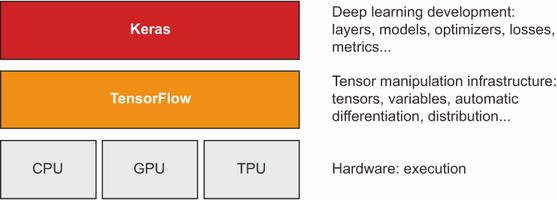

## Primeros pasos con TensorFlow

Entrenar redes neuronales gira en torno a varios conceptos:

1. La manipulación de tensores, la *infraestructura* que subyace a todo el aprendizaje automático moderno. Esto se traduce en las APIs de **TensorFlow**:
 * *Tensores*, incluyendo tensores especiales que almacenan el estado de la red (variables)
 * *Operaciones de tensor* como la `suma`, `relu`, `matmul`
 * *Retropropagación (Backpropagation)*, una forma de calcular el gradiente de expresiones matemáticas (usado TensorFlow a través del objeto `GradientTape`)
2. Conceptos de aprendizaje profundo de alto nivel. Esto se traduce en las APIs de **Keras**:
 * *Capas*, que se combinan en un modelo
 * *Función de pérdida*, que define la señal de retroalimentación utilizada para el aprendizaje
 * *Optimizador*, que determina cómo se realiza el ajuste/aprendizaje a los datos.
 * *Métricas* para evaluar el rendimiento del modelo, como la precisión
 * Un *bucle de entrenamiento* que realiza el descenso de gradiente estocástico en mini lotes

#### Tensores constantes y variables

Los tensores son la estructura de datos básica de TensorFlow y Keras. Deben crearse con un contenido y no se les puede asignar un valor.

Cuando es necesario cambiar el estado de una variable necesitaremos el tipo `tf.Variable`, que deben crearse con un valor inicial también.

**All-ones o all-zeros tensors**

In [45]:
import tensorflow as tf
x = tf.ones(shape=(2, 1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


In [46]:
x = tf.zeros(shape=(2, 1))
print(x)

tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


**Tensores aleatorios**

In [47]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

tf.Tensor(
[[-1.0824244 ]
 [ 0.76706594]
 [ 0.00492683]], shape=(3, 1), dtype=float32)


In [48]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[0.3706274 ]
 [0.5128211 ]
 [0.45267677]], shape=(3, 1), dtype=float32)


**Los arrays de NumPy son asignables pero los tensores no**

In [49]:
import numpy as np
x = np.ones(shape=(2, 2))
x[0, 0] = 0.

In [50]:
try:
  x = tf.ones(shape=(2, 2))
  x[0, 0] = 0.
except Exception as e:
  print(e)

'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment


**Crear un TensorFlow variable**

In [51]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[1.5894972],
       [1.3169332],
       [0.5858152]], dtype=float32)>


**Asignar un valor a un TensorFlow variable**

In [52]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

**Asignar un valor a un subconjunto de un TensorFlow variable**

In [53]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

**Suma con `assign_add`**

In [54]:
v.assign_add(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

#### Operaciones matemáticas con Tensores

**Operaciones básicas**

In [55]:
a = tf.ones((2, 2))
b = tf.square(a)
c = tf.sqrt(a)
d = b + c
e = tf.matmul(a, b)
e *= d

#### GradientTape API

**Cómo usar `GradientTape`**

Basta con abrir un *ámbito* de `GradientTape`, aplicar algún cálculo a uno o varios tensores de entrada, y recuperar el gradiente del resultado con respecto a las entradas.

$f(x)=x^2$

$
\frac{\partial f}{\partial x} = 2x
$



In [56]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
   result = tf.square(input_var)
gradient = tape.gradient(result, input_var)
# la función sería f(x)=x^2; f'(x)=2x, siendo x = 3 f'(x)=6
print(input_var)
print(gradient)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0>
tf.Tensor(6.0, shape=(), dtype=float32)


**`GradientTape` con tensores constantes como entrada**

Hasta ahora, sólo hemos visto el caso en que los tensores de entrada en `tape.gradient()` eran variables TensorFlow. En realidad es posible que estas entradas sean cualquier tensor arbitrario. Sin embargo, sólo las variables entrenables son *rastreadas* por defecto. Con un tensor constante, hay que marcarlo manualmente como rastreado llamando a `tape.watch()` sobre él. Esto se hace por motivos de eficiencia computacional.

In [57]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
   tape.watch(input_const)
   result = tf.square(input_const)
gradient = tape.gradient(result, input_const)
print(result)
print(gradient)

tf.Tensor(9.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


#### Un clasificador lineal completo en TensorFlow

**Generación del conjunto de datos**

In [58]:
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

In [59]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

In [60]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

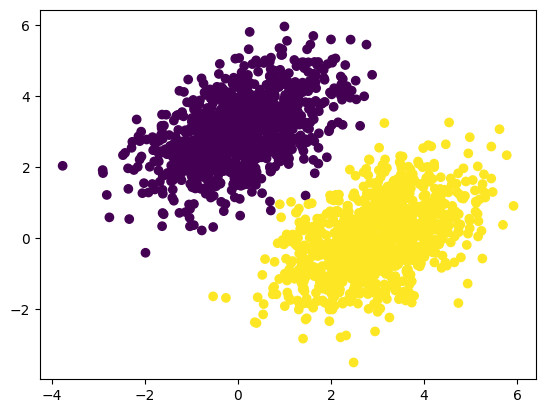

In [61]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

**Creación de la variables del modelo lineal**

Inicializamos `W` con valores aleatorios y `b` a cero.


In [62]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

**Propagación hacia delante**

In [63]:
def model(inputs):
    return tf.matmul(inputs, W) + b

**Función de pérdia de error cuadrático medio (MSE)**

* `persample_loss` es un tensor con la misma forma que targets y predictions y almacenará la pérdida correspondiente a cada patrón.
* Devolvemos la contribución media al error del lote. `reduce_mean` por defecto reduce todas las dimensiones a 1, pero podría utilizarse para calcular medias por ejes del tensor.

In [64]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    #return tf.sqrt(tf.reduce_mean(per_sample_losses))
    return tf.reduce_mean(per_sample_losses)

**El paso de entrenamiento**

Recordad que `GradientTape` nos permite derivar respecto a listas de parámetros. En este caso nos devuelve el gradiente parcial respecto a cada parámetro de la lista.

In [65]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    # Actualizamos los pesos restando el gradiente (dirección contraria)
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

**Bucle de aprendizaje con el conjunto completo (batch training)**

Para simplificar, haremos un entrenamiento por lotes en lugar de un mini-entrenamiento por lotes: ejecutaremos cada paso de entrenamiento (cálculo del gradiente y actualización de pesos) para todos los datos, en lugar de iterar sobre los datos en pequeños lotes.

Esto significa que cada paso de entrenamiento tardará mucho más tiempo en ejecutarse pero cada actualización del gradiente será mucho más eficaz para reducir la función de pérdida al incluir todos los datos de entrenamiento. Esto significa que harán falta menos pasos de entrenamiento y que la tasa de aprendizaje debería ser mayor que al utilizar lotes pequeños (`learning_rate = 0.1`).

❓❓❓ **EJERCICIO**
* Prueba a utilizar distintas tasas de aprendizaje en este ejemplo y observa el resultado
* ¿[Tiene sentido que la tasa de aprendizaje sea mayor que 1](https://ai.stackexchange.com/questions/23740/why-is-the-learning-rate-generally-beneath-1)?
* Intenta programar otra función de pérdida: el RMSE.

❓❓❓

In [66]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 1.2430
Loss at step 1: 0.2257
Loss at step 2: 0.1199
Loss at step 3: 0.1013
Loss at step 4: 0.0935
Loss at step 5: 0.0875
Loss at step 6: 0.0822
Loss at step 7: 0.0773
Loss at step 8: 0.0729
Loss at step 9: 0.0688
Loss at step 10: 0.0651
Loss at step 11: 0.0617
Loss at step 12: 0.0586
Loss at step 13: 0.0558
Loss at step 14: 0.0532
Loss at step 15: 0.0508
Loss at step 16: 0.0486
Loss at step 17: 0.0466
Loss at step 18: 0.0448
Loss at step 19: 0.0432
Loss at step 20: 0.0416
Loss at step 21: 0.0402
Loss at step 22: 0.0390
Loss at step 23: 0.0378
Loss at step 24: 0.0367
Loss at step 25: 0.0358
Loss at step 26: 0.0349
Loss at step 27: 0.0341
Loss at step 28: 0.0333
Loss at step 29: 0.0326
Loss at step 30: 0.0320
Loss at step 31: 0.0315
Loss at step 32: 0.0309
Loss at step 33: 0.0305
Loss at step 34: 0.0300
Loss at step 35: 0.0296
Loss at step 36: 0.0293
Loss at step 37: 0.0289
Loss at step 38: 0.0286
Loss at step 39: 0.0284


In [67]:
def rmse_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.sqrt(tf.reduce_mean(per_sample_losses))
    # return tf.reduce_mean(per_sample_losses)

In [68]:
def training_step(inputs, targets, learning_rate=0.1):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = rmse_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    # Actualizamos los pesos restando el gradiente (dirección contraria)
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

learning_rate = 0.05

for step in range(40):
    loss = training_step(inputs, targets, learning_rate)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 0.1676
Loss at step 1: 0.1666
Loss at step 2: 0.1657
Loss at step 3: 0.1649
Loss at step 4: 0.1642
Loss at step 5: 0.1636
Loss at step 6: 0.1630
Loss at step 7: 0.1625
Loss at step 8: 0.1621
Loss at step 9: 0.1618
Loss at step 10: 0.1614
Loss at step 11: 0.1612
Loss at step 12: 0.1609
Loss at step 13: 0.1607
Loss at step 14: 0.1605
Loss at step 15: 0.1604
Loss at step 16: 0.1602
Loss at step 17: 0.1601
Loss at step 18: 0.1600
Loss at step 19: 0.1599
Loss at step 20: 0.1598
Loss at step 21: 0.1598
Loss at step 22: 0.1597
Loss at step 23: 0.1596
Loss at step 24: 0.1596
Loss at step 25: 0.1596
Loss at step 26: 0.1595
Loss at step 27: 0.1595
Loss at step 28: 0.1595
Loss at step 29: 0.1594
Loss at step 30: 0.1594
Loss at step 31: 0.1594
Loss at step 32: 0.1594
Loss at step 33: 0.1594
Loss at step 34: 0.1594
Loss at step 35: 0.1594
Loss at step 36: 0.1594
Loss at step 37: 0.1593
Loss at step 38: 0.1593
Loss at step 39: 0.1593


In [69]:
def training_step(inputs, targets, learning_rate=0.1):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = new_square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    # Actualizamos los pesos restando el gradiente (dirección contraria)
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

learning_rate = 1

for step in range(40):
    loss = training_step(inputs, targets, learning_rate)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 0.1593
Loss at step 1: 0.1593
Loss at step 2: 0.1593
Loss at step 3: 0.1684
Loss at step 4: 2.1294
Loss at step 5: 4.5875
Loss at step 6: 2.1442
Loss at step 7: 4.5731
Loss at step 8: 2.1587
Loss at step 9: 4.5588
Loss at step 10: 2.1729
Loss at step 11: 4.5448
Loss at step 12: 2.1868
Loss at step 13: 4.5311
Loss at step 14: 2.2005
Loss at step 15: 4.5176
Loss at step 16: 2.2139
Loss at step 17: 4.5044
Loss at step 18: 2.2271
Loss at step 19: 4.4913
Loss at step 20: 2.2401
Loss at step 21: 4.4786
Loss at step 22: 2.2528
Loss at step 23: 4.4660
Loss at step 24: 2.2654
Loss at step 25: 4.4536
Loss at step 26: 2.2777
Loss at step 27: 4.4415
Loss at step 28: 2.2898
Loss at step 29: 4.4295
Loss at step 30: 2.3017
Loss at step 31: 4.4177
Loss at step 32: 2.3134
Loss at step 33: 4.4061
Loss at step 34: 2.3250
Loss at step 35: 4.3947
Loss at step 36: 2.3363
Loss at step 37: 4.3835
Loss at step 38: 2.3475
Loss at step 39: 4.3725


El learning rate controla el tamaño de los pasos que el algoritmo de optimización da en el espacio de los parámetros durante el proceso de entrenamiento. Si la tasa de aprendizaje es demasiado grande, los pasos pueden ser tan grandes que el algoritmo de optimización puede diverger y no converger hacia una solución óptima. En el caso de ser muy pequeños puede que caiga en un óptimo local y no pueda salir o que no consiga diverger lo suficiente.

Lo ideal es buscar un valor intermedio y hacer diferentes experimentos.

En los experimentos anteriores, el primero apenas divergia y en el último no ha conseguido converger nada.

In [70]:
learning_rate = 0.05

for step in range(40):
    loss = training_step(inputs, targets, learning_rate)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 2.3585
Loss at step 1: 2.0238
Loss at step 2: 1.6898
Loss at step 3: 1.3568
Loss at step 4: 1.0258
Loss at step 5: 0.6995
Loss at step 6: 0.3878
Loss at step 7: 0.1661
Loss at step 8: 0.1664
Loss at step 9: 0.1667
Loss at step 10: 0.1670
Loss at step 11: 0.1672
Loss at step 12: 0.1674
Loss at step 13: 0.1675
Loss at step 14: 0.1676
Loss at step 15: 0.1677
Loss at step 16: 0.1678
Loss at step 17: 0.1679
Loss at step 18: 0.1680
Loss at step 19: 0.1680
Loss at step 20: 0.1680
Loss at step 21: 0.1681
Loss at step 22: 0.1681
Loss at step 23: 0.1681
Loss at step 24: 0.1681
Loss at step 25: 0.1681
Loss at step 26: 0.1681
Loss at step 27: 0.1682
Loss at step 28: 0.1682
Loss at step 29: 0.1682
Loss at step 30: 0.1682
Loss at step 31: 0.1682
Loss at step 32: 0.1682
Loss at step 33: 0.1682
Loss at step 34: 0.1682
Loss at step 35: 0.1682
Loss at step 36: 0.1682
Loss at step 37: 0.1682
Loss at step 38: 0.1682
Loss at step 39: 0.1682


Como vemos la función de pérdida más o menos se estabiliza.

Ahora vamos a predecir la clase de los patrones. En este ejemplo de clasificación binaria el umbral de decisión entre las clases es `0.5` donde se asigna la clase "1" para los valores mayores que el umbral.

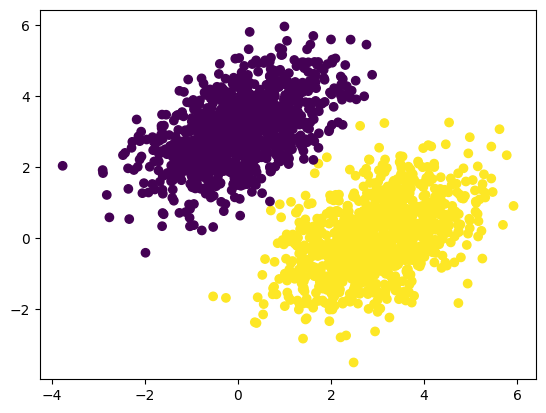

In [71]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

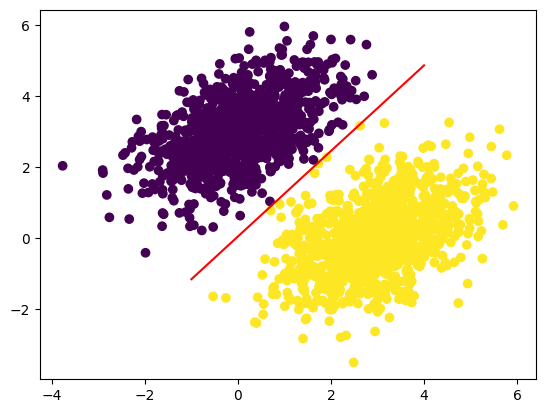

In [72]:
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

## Anatomía de una red neuronal para entender conceptos de Keras

### Capas (Layers)

La estructura de datos fundamental en las redes neuronales es la *capa*. Una capa es un módulo de procesamiento de datos que toma como entrada uno o más tensores y que da como salida uno o más tensores. Algunas capas no tienen estado, pero lo más frecuente es que las capas tengan un estado: los *pesos* de la capa, uno o varios tensores aprendidos con el descenso por gradiente, que en conjunto almacenan el *conocimiento* de la red.

Según el tipo de dato con el que trabajemos habrá tipos de capas más apropiados para trabajar con estos.
* Datos vectoriales simples, también llamados tabulares ("hoja de cálculo"), almacenados en tensores de rango 2 `(muestra, características)`, suelen ser procesados por capas densamente conectadas, también llamadas capas totalmente conectadas (la clase `Dense` en Keras).
* Los datos con disposición temporal o de secuencia, tensores de rango 3 `(muestras, pasos de tiempo, características)`, se procesan normalmente por capas recurrentes, como una capa `LSTM`, o capas de convolución 1D (`Conv1D`).
* Los datos de imágenes, almacenados en tensores de rango 4, suelen ser procesados por capas de convolución 2D (`Conv2D`).

#### La clase `Layer` en Keras


Casi todo en Keras gira en torno a un objeto de tipo Layer, que encapsula un estado de los pesos y un cálculo sobre la red (*forward pass*). Los pesos se definen en `build()` y el procesamiento en `call()`.


**Una capa `Dense` implementada como subclase de `Layer`**

In [73]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")

    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

Esta capa que hemos creado se puede instanciar y usarse como una función:

In [74]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 32)


In [75]:
my_dense = SimpleDense(units=512, activation=tf.nn.tanh)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 512)


#### Deducción de la forma de la capa automática: construcción de capas sobre la marcha

En Keras en general sólo necesitaremos especificar la forma de los tensores de salida de la capa, ya que las capas que se añaden al modelo se construyen dinámicamente para adaptar cada capa a la forma de la capa de entrada (la salida de la capa anterior).

La siguiente capa sólo puede conectarse a una capa que espere vectores de 32 dimensiones como entrada.

In [76]:
from tensorflow.keras import layers
layer = layers.Dense(32, activation="relu")

En Keras, no se implementa la construcción de la capa del todo en el constructor `__build__()` en espera de conocer cuál será la forma de la entrada desde la capa anterior.

In [77]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32)
])

En el ejemplo de red que hicimos desde cero necesitábamos especificar perfectamente las dimensiones de entrada y salida de la secuencia de capas:

```
model = NaiveSequential([
    NaiveDense(input_size=784, output_size=32, activation="relu"),
    NaiveDense(input_size=32, output_size=64, activation="relu"),
    NaiveDense(input_size=64, output_size=32, activation="relu"),
    NaiveDense(input_size=32, output_size=10, activation="softmax")
])
```



En Keras basta con lo siguiente:

In [78]:
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(10, activation="softmax")
])

### De las capas a los modelos

Un modelo de aprendizaje profundo consiste en un grafo de capas, clase `Model` en Keras. Hasta ahora sólo hemos visto el modelo `Sequential`, que es una subclase de `Model` pero existen muchas otras topologías de red más avanzadas (Transformers, Residual...)

### El paso "compile" step para configurar el proceso de aprendizaje

Aquí vamos a configurar:
* Función de pérdida (o función objetivo).
* El optimizador.
* Métricas de evaluación sobre el conjunto de train y opcionalmente validación.

Hay dos alternativas para especificar:

In [79]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["accuracy"])

In [80]:
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

### La importancia de la función de pérdida ❗❗❗❗

La elección de la función de pérdida correcta para el problema adecuado es extremadamente importante: la red tomará cualquier atajo que pueda para minimizar la pérdida, por lo que si el objetivo no está totalmente correlacionado con la tarea en cuestión, la red terminará haciendo cosas que probablemente no queramos.

Ejemplos:
* ¿detector de emociones?
* ¿maximizar el bienestar promedio de los seres humanos?

### El método fit()

**Calling `fit()` with NumPy data**

In [81]:
history = model.fit(
    inputs,
    targets,
    epochs=5,
    batch_size=128
)

Epoch 1/5
16/16 [==============================] - 0s 2ms/step - loss: 11.8482 - binary_accuracy: 0.0040
Epoch 2/5
16/16 [==============================] - 0s 2ms/step - loss: 11.4442 - binary_accuracy: 0.0040
Epoch 3/5
16/16 [==============================] - 0s 2ms/step - loss: 11.1028 - binary_accuracy: 0.0040
Epoch 4/5
16/16 [==============================] - 0s 2ms/step - loss: 10.7744 - binary_accuracy: 0.0040
Epoch 5/5
16/16 [==============================] - 0s 3ms/step - loss: 10.4506 - binary_accuracy: 0.0040


In [82]:
history.history

{'loss': [11.848226547241211,
  11.44420051574707,
  11.102790832519531,
  10.774447441101074,
  10.45063591003418],
 'binary_accuracy': [0.004000000189989805,
  0.004000000189989805,
  0.004000000189989805,
  0.004000000189989805,
  0.004000000189989805]}

### Monitorización de la pérdida y las métricas sobre datos de validación

**Parámetro `validation_data`**


In [83]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]
model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)

Epoch 1/5
88/88 [==============================] - 2s 16ms/step - loss: 0.2540 - binary_accuracy: 0.9000 - val_loss: 0.1137 - val_binary_accuracy: 0.9667
Epoch 2/5
88/88 [==============================] - 1s 7ms/step - loss: 0.0681 - binary_accuracy: 0.9557 - val_loss: 0.0368 - val_binary_accuracy: 0.9917
Epoch 3/5
88/88 [==============================] - 0s 5ms/step - loss: 0.0732 - binary_accuracy: 0.9536 - val_loss: 0.1043 - val_binary_accuracy: 0.9083
Epoch 4/5
88/88 [==============================] - 0s 5ms/step - loss: 0.0660 - binary_accuracy: 0.9614 - val_loss: 0.1570 - val_binary_accuracy: 0.8383
Epoch 5/5
88/88 [==============================] - 0s 5ms/step - loss: 0.0749 - binary_accuracy: 0.9529 - val_loss: 0.0662 - val_binary_accuracy: 0.9683


### Cómo usar el modelo entrenado

Se puede llamar al modelo como una función, pero esto evaluaría toda la base de datos de test directamente en lugar de por lotes.

```
predictions = model(new_inputs)
```

Habitualmente será más adecuado usar la función `predict`

In [84]:
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

5/5 [==============================] - 0s 3ms/step
[[ 0.9528202 ]
 [-0.26752287]
 [ 1.0997298 ]
 [-0.20845133]
 [ 0.00442219]
 [ 0.7651191 ]
 [-0.3744483 ]
 [ 0.0456185 ]
 [-0.17519575]
 [-0.0816631 ]]


❓❓❓
**EJERCICIO**

* Prueba a utilizar el modelo anterior de 4 capas con la base de datos MNIST
  * No bastará con copiar y pegar. Presta atención a: variables de entrada, función de pérdida adecuada, neuronas por capa... Deberás calcular la precisión media en test.
* Prueba a visualizar el historial de ajuste del modelo

❓❓❓

In [93]:
from tensorflow.keras.datasets import mnist

# Cargar la base de datos MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

# Modelo
model = Sequential([
    Dense(32, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(10, activation="softmax")
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Paso 3: Entrenar el modelo
history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 3s 7ms/step - loss: 0.5468 - accuracy: 0.8330 - val_loss: 0.2504 - val_accuracy: 0.9264
Epoch 2/10
375/375 [==============================] - 1s 4ms/step - loss: 0.2219 - accuracy: 0.9344 - val_loss: 0.1851 - val_accuracy: 0.9454
Epoch 3/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1653 - accuracy: 0.9507 - val_loss: 0.1624 - val_accuracy: 0.9531
Epoch 4/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1391 - accuracy: 0.9597 - val_loss: 0.1448 - val_accuracy: 0.9591
Epoch 5/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1174 - accuracy: 0.9651 - val_loss: 0.1340 - val_accuracy: 0.9613
Epoch 6/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1049 - accuracy: 0.9692 - val_loss: 0.1332 - val_accuracy: 0.9601
Epoch 7/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0941 - accuracy: 0.9717 - val_loss: 0.1255 - val_accuracy: 0.9627
Epoch 

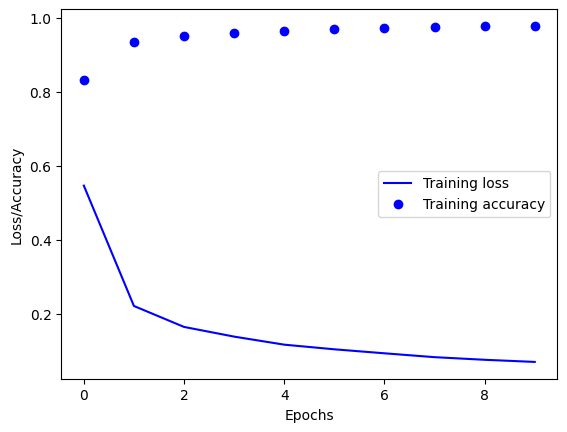

In [94]:
import matplotlib.pyplot as plt

# Puedes usar este código para visualizar el histórico de entrenamiento
history_dict = history.history
loss_values = history_dict["loss"]
acc_values = history_dict["accuracy"]
plt.plot(loss_values, "b-", label="Training loss")
plt.plot(acc_values, "bo", label="Training accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## Resumen
* TensorFlow es un *framework* que puede ejecutarse en CPU, GPU y TPU.
* TensorFlow puede calcular el gradiente de cualquier expresión diferenciable.
* Keras es un API para hacer modelos de aprendizaje profundo con TF.
* Objetos claves de TF: tensores, variables, operaciones con tensores y *GradientTape*.
* La clase central de Keras es `Layer`, que encapsula algunos pesos y cálculos. Las capas se unen o ensamblan en **modelos**.
* Antes de entrenar un modelo es necesario elegir un **optimizador**, una **función de pérdida** y una o varias **métricas**: `model.compile()`
* El método `model.fit()` ejecuta el descenso por gradiente por mini-lotes. Permite monitorizar la pérdida y métricas y incluir datos de **validación**.
* Con el modelo entrenado, se pueden hacer predicciones con `model.predict()`.